# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [133]:
!pip install datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


^C
ERROR: Operation cancelled by user


Download the dataset

In [134]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

Filter row with length greater than 8.


In [135]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


KeyboardInterrupt: 

Create a tokenizer and Detokenizer

In [ ]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [ ]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [ ]:
original_data.shape

Shuffle the sentences

In [ ]:
def extract_full_data(generator):
    x_list = []
    y_list = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
    x = np.concatenate(x_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return x, y

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [ ]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [ ]:
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [ ]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size/max(len(p),len(s)))

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

In [ ]:
x_train, y_train = extract_full_data(train_generator)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = extract_full_data(test_generator)
x_test.shape, y_test.shape

In [ ]:
vocabulary = tokenizer.get_vocabulary()

In [ ]:
x_train, y_train = extract_full_data(train_generator)
x_train.shape, x_train.shape

In [ ]:
from keras.utils import pad_sequences
def prepare_dataset(X, Y):
  c_set = pad_sequences(np.array([s[1:] for s in X]), maxlen=28, padding='post')
  x_set = Y
  y_set = pad_sequences(np.array([s[1:] for s in Y]), maxlen=28, padding='post')
  context = []
  labels = []
  inputs= []

  for j,x in enumerate(x_set):
    non_null_count = sum(x>0)-2
    for i in range(non_null_count):
      context.append(c_set[j])
      inputs.append(pad_sequences([x[:i+1]], maxlen=28, padding='post')[0])
      labels.append(y_set[j])

  return np.array(context), np.array(inputs), np.array(labels)


In [ ]:
x_train.shape

In [ ]:
context_train, inputs_train, labels_train = prepare_dataset(x_train[:200000], y_train[:200000])
context_val, inputs_val, labels_val = prepare_dataset(x_train[200000:], y_train[200000:])
context_test, inputs_test, labels_test = prepare_dataset(x_test, y_test)

In [ ]:
len(context_train)

In [ ]:
import numpy as np
import tensorflow as tf
import keras.backend as k
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = embedder

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # The last attention scores are cached for later plotting
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x
  
import keras

@keras.saving.register_keras_serializable()
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # All inputs must be passed in the first argument to use '.fit'

    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Keras mask is dropped, so it doesn't scale with losses or metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

@keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  def get_config(self):
        return {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
        }



# num_layers = 8
num_layers = 8
# d_model = 128
d_model = 128
# dff = 512
dff = 128
# num_heads = 8
num_heads = 4
dropout_rate = 0.2
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10_000,
    target_vocab_size=10_000,
    dropout_rate=dropout_rate)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

K_VALUE = 0.97

# Defining a custom loss function that works directly on tokens
def custom_masked_loss(label, pred):

    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    final_array = tf.pow(K_VALUE,tf.cast(tf.range(1,28+1),tf.float32))

    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

# Defining a custom metric that works directly on tokens
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

transformer.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

transformer.build(input_shape = [(None, 28), (None, 28)])

transformer.summary()

In [ ]:
transformer.summary()

In [ ]:
# print(custom_masked_loss(y_train[0],result))
transformer.fit(
    (context_train[:1], inputs_train[:1]),
    labels_train[:1],
    epochs=1,
    batch_size=1,
    # callbacks = [es],
    validation_data = ((context_val[:1], inputs_val[:1]), labels_val[:1]))
transformer.summary()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
context_train.shape, context_val.shape, context_test.shape

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 5
batch_size= 128

checkpoint_filepath = '/content/drive/MyDrive/UNIBO_DEEP_LEARNING/latest.weights.h5'
checkpoint_filepath = './latest.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    save_best_only=True,
    monitor='masked_accuracy',# Only save the weights
    save_freq=1000,          # Save every 1000 weight updates
    verbose=1                # Verbosity level (optional)
)
history = transformer.fit(
    (context_train, inputs_train),
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, es],
    validation_data = ((context_val, inputs_val), labels_val)
)

In [ ]:
transformer.save_weights("weights_final.weights.h5", overwrite=True)


In [ ]:

num_layers = 3
# d_model = 128
d_model = 64
# dff = 512
dff = 64
# num_heads = 8
num_heads = 3
dropout_rate = 0.2
transformer_small = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10_000,
    target_vocab_size=10_000,
    dropout_rate=dropout_rate)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer_small.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

transformer_small.build(input_shape = [(None, 28), (None, 28)])

transformer_small.summary()


In [ ]:
transformer_small.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 2
batch_size= 128

checkpoint_filepath = '/content/drive/MyDrive/UNIBO_DEEP_LEARNING/latest.weights.h5'
checkpoint_filepath = './latest_small.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    save_best_only=True,
    monitor='masked_accuracy',# Only save the weights
    save_freq=1000,          # Save every 1000 weight updates
    verbose=1                # Verbosity level (optional)
)
history = transformer_small.fit(
    (context_train, inputs_train),
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, es],
    validation_data = ((context_val, inputs_val), labels_val)
)

In [ ]:

num_layers = 8
# d_model = 128
d_model = 128
# dff = 512
dff = 128
# num_heads = 8
num_heads = 8
dropout_rate = 0.2
transformer_big = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10_000,
    target_vocab_size=10_000,
    dropout_rate=dropout_rate)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer_big.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

transformer_big.build(input_shape = [(None, 28), (None, 28)])

transformer_big.summary()


In [ ]:
transformer_big.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 1
batch_size= 128

checkpoint_filepath = '/content/drive/MyDrive/UNIBO_DEEP_LEARNING/latest.weights.h5'
checkpoint_filepath = './latest_big.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    save_best_only=True,
    monitor='masked_accuracy',# Only save the weights
    save_freq=1000,          # Save every 1000 weight updates
    verbose=1                # Verbosity level (optional)
)
history = transformer_big.fit(
    (context_train, inputs_train),
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, es],
    validation_data = ((context_val, inputs_val), labels_val)
)

In [ ]:
average_random_score, average_generated_score = get_average_score(x_test[2000:2100], y_test[2000:2100], transformer_big)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [ ]:
average_random_score, average_generated_score = get_average_score(x_test[2000:2100], y_test[2000:2100], transformer_small)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [ ]:
average_random_score, average_generated_score = get_average_score(x_train[2000:2100], y_train[2000:2100], transformer_small)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [ ]:
transformer2.get_weights()

In [ ]:

np.argmax(transformer.predict((np.array([context_train[0]]), np.array([inputs_train[0]]))),axis=-1) == np.argmax(transformer2.predict((np.array([context_train[0]]), np.array([inputs_train[0]]))),axis=-1)


In [ ]:

result = transformer.predict((np.array([context_train[0]]), np.array([inputs_train[0]])))

In [ ]:
np.argmax(result,axis=2), labels_train[0]

In [ ]:
score(x[i],y[i])

In [ ]:
# result = transformer.predict((np.array([context_train[1]]), np.array([inputs_train[1]])))
# score(labels_train[1],tf.argmax(result, axis=2)[0])

In [ ]:
# context_train[0]

In [ ]:
# labels_train[0]

In [ ]:
available_tokens = context_train[0][1:sum((context_train[0]>0))-1].tolist()
print(available_tokens)
relevant_logits = result[0, 0, available_tokens]
print(relevant_logits)
available_tokens[np.argmax(relevant_logits,axis=-1)]

In [ ]:
vocabulary_size = len(vocabulary)
batch_size = 32

In [ ]:
test_generator = ModifiedDataGenerator((x_test,y_test), batch_size=batch_size, vocabulary_size=vocabulary_size)
train_generator = ModifiedDataGenerator((x_train,y_train), batch_size=batch_size, vocabulary_size=vocabulary_size)


In [163]:
from difflib import SequenceMatcher
from keras.preprocessing.sequence import pad_sequences

def score(s, p):
    match = SequenceMatcher(None, s, p).find_longest_match(0, len(s), 0, len(p))
    return match.size / max(len(p), len(s))

# Limit the number of examples for testing

def generate_prediction(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0) 
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = available_tokens[generated_index]
        available_tokens.remove(generated_token)
        generated[count+1] = generated_token
    
    return generated[1:sum(generated>0)]

# def generate_prediction2(shuffled, model):
#     max_count = sum(shuffled > 3)
#     generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
# #     available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
#     context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
#     for count in range(max_count):
#         prediction = model.predict((np.array([context]), np.array([generated])), verbose=0) 
#         relevant_logits = prediction[0, count, :]
#         generated_index = np.argmax(relevant_logits, axis=-1)
#         generated_token = generated_index
# #         generated_token = available_tokens[generated_index]
# #         available_tokens.remove(generated_token)
#         generated[count+1] = generated_token
    
#     generated[sum(generated>0)] = 2
#     return generated[:sum(generated>0)]
# def get_average_score2(x, y, model):
#     num_examples = len(x)
#     rs = []
#     gs = []
#     for i in range(num_examples):
#         shuffled = x[i][:sum(x[i]>0)]
#         ordered = y[i][:sum(y[i]>0)]

#         rs.append(score(ordered, shuffled))
#         gs.append(score(ordered, generate_prediction2(x[i],model)))
#         print(f'{i+1}.Random: {rs[-1]}')
#         print(f'{i+1}.Generated: {gs[-1]}')

#     return sum(rs)/num_examples, sum(gs)/num_examples
def get_average_score(x, y, model, print_allowed=False):
    num_examples = len(x)
    rs = []
    gs = []
    for i in range(num_examples):
        shuffled = x[i][1:sum(x[i]>0)-1]
        ordered = y[i][1:sum(y[i]>0)-1]

        rs.append(score(ordered, shuffled))
        gs.append(score(ordered, generate_prediction(x[i],model)))
        if print_allowed:
            print(f'{i+1}.Random: {rs[-1]}')
            print(f'{i+1}.Generated: {gs[-1]}')

    return gs, sum(rs)/num_examples, sum(gs)/num_examples

In [ ]:
average_random_score, average_generated_score = get_average_score(x_train[2000:2100], y_train[2000:2100], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [ ]:
average_random_score, average_generated_score = get_average_score(x_test[2000:2100], y_test[2000:2100], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [161]:
import tensorflow as tf
import keras_nlp
import numpy as np

# Positional Encoding Function
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Custom Positional Embedding Class
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

import keras

@keras.saving.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder_embedding = PositionalEmbedding(input_vocab_size, d_model)
        self.decoder_embedding = PositionalEmbedding(target_vocab_size, d_model)
        self.encoder_layers = [keras_nlp.layers.TransformerEncoder(
            intermediate_dim=dff,
            num_heads=num_heads,
            dropout=dropout_rate, activation='swish'
        ) for _ in range(num_layers)]
        self.decoder_layers = [keras_nlp.layers.TransformerDecoder(
            intermediate_dim=dff,
            num_heads=num_heads,
            dropout=dropout_rate, activation='swish'
        ) for _ in range(num_layers)]
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='swish')

    def call(self, inputs):
        context, x = inputs
        context_mask = self.encoder_embedding.compute_mask(context)
        x_mask = self.decoder_embedding.compute_mask(x)
        
        context = self.encoder_embedding(context)
        for layer in self.encoder_layers:
            context = layer(context, padding_mask=context_mask)
        
        x = self.decoder_embedding(x)
        for layer in self.decoder_layers:
            x = layer(x, context, decoder_padding_mask=x_mask, encoder_padding_mask=context_mask)
        
        logits = self.final_layer(x)
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

@keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {'d_model': self.d_model, 'warmup_steps': self.warmup_steps}

# Model Hyperparameters
num_layers = 16
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.2
input_vocab_size = 10000
target_vocab_size = 10000

# Instantiate the Transformer Model
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate
)

# Learning Rate and Optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Custom Loss Function
K_VALUE = 0.97

def custom_masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
#     1
#     final_array = tf.pow(K_VALUE, tf.cast(tf.range(1, 28 + 1), tf.float32))
    first_part = tf.pow(K_VALUE, tf.cast(tf.range(1, 6 + 1), tf.float32))
    second_part = tf.pow(K_VALUE, tf.cast(tf.range(1, 22 + 1), tf.float32))

# Reverse the first part
    reversed_first_part = tf.reverse(first_part, axis=[0])

# Concatenate the reversed first part with the second part
    final_array = tf.concat([reversed_first_part, second_part], axis=0)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    mask *= final_array
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Compile the Model
transformer.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

# Build and Display the Model Summary
transformer.build(input_shape=[(None, 28), (None, 28)])
transformer.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_34         │ ?                      │   0 (unbuilt) │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_35         │ ?                      │   0 (unbuilt) │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_177         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_178         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_179         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_180         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_181         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_182         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_183         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_184         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_185         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_186         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_187         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_188         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_189         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_190         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_191         │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [162]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 5
batch_size= 128

checkpoint_filepath = '/content/drive/MyDrive/UNIBO_DEEP_LEARNING/latest.weights.h5'
checkpoint_filepath = './latest_2.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    save_best_only=True,
    monitor='masked_accuracy',# Only save the weights
    save_freq=1000,          # Save every 1000 weight updates
    verbose=1                # Verbosity level (optional)
)
history = transformer.fit(
    (context_train, inputs_train),
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, es],
    validation_data = ((context_val, inputs_val), labels_val)
)

Epoch 1/5


W0000 00:00:1717860699.552913     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  999/19272 ━━━━━━━━━━━━━━━━━━━━ 47:09 155ms/step - loss: 8.0514 - masked_accuracy: 0.1459
Epoch 1: masked_accuracy improved from -inf to 0.21420, saving model to ./latest_2.weights.h5
 1999/19272 ━━━━━━━━━━━━━━━━━━━━ 44:47 156ms/step - loss: 7.0642 - masked_accuracy: 0.2027
Epoch 1: masked_accuracy improved from 0.21420 to 0.30043, saving model to ./latest_2.weights.h5
 2999/19272 ━━━━━━━━━━━━━━━━━━━━ 42:17 156ms/step - loss: 6.3681 - masked_accuracy: 0.2453
Epoch 1: masked_accuracy improved from 0.30043 to 0.35614, saving model to ./latest_2.weights.h5
 3999/19272 ━━━━━━━━━━━━━━━━━━━━ 39:41 156ms/step - loss: 5.8460 - masked_accuracy: 0.2777
Epoch 1: masked_accuracy improved from 0.35614 to 0.39100, saving model to ./latest_2.weights.h5
 4999/19272 ━━━━━━━━━━━━━━━━━━━━ 37:07 156ms/step - loss: 5.4396 - masked_accuracy: 0.3031
Epoch 1: masked_accuracy improved from 0.39100 to 0.41757, saving model to ./latest_2.weights.h5
 5999/19272 ━━━━━━━━━━━━━━━━━━━━ 34:31 156ms/step - loss: 5.110

W0000 00:00:1717863834.616378     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717863850.057898     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19272/19272 ━━━━━━━━━━━━━━━━━━━━ 3489s 169ms/step - loss: 3.2404 - masked_accuracy: 0.4651 - val_loss: 1.4043 - val_masked_accuracy: 0.6502
Epoch 2/5
  727/19272 ━━━━━━━━━━━━━━━━━━━━ 47:41 154ms/step - loss: 0.8988 - masked_accuracy: 0.7337
Epoch 2: masked_accuracy improved from 0.58810 to 0.73492, saving model to ./latest_2.weights.h5
 1727/19272 ━━━━━━━━━━━━━━━━━━━━ 45:33 156ms/step - loss: 0.8967 - masked_accuracy: 0.7348
Epoch 2: masked_accuracy improved from 0.73492 to 0.73653, saving model to ./latest_2.weights.h5
 2727/19272 ━━━━━━━━━━━━━━━━━━━━ 43:00 156ms/step - loss: 0.8932 - masked_accuracy: 0.7360
Epoch 2: masked_accuracy improved from 0.73653 to 0.73937, saving model to ./latest_2.weights.h5
 3727/19272 ━━━━━━━━━━━━━━━━━━━━ 40:23 156ms/step - loss: 0.8890 - masked_accuracy: 0.7372
Epoch 2: masked_accuracy improved from 0.73937 to 0.74224, saving model to ./latest_2.weights.h5
 4727/19272 ━━━━━━━━━━━━━━━━━━━━ 37:48 156ms/step - loss: 0.8846 - masked_accuracy: 0.7386
Epoch 2

KeyboardInterrupt: 

In [ ]:
transformer.summary()

In [154]:


# Print the combined array
print(combined_array)


tf.Tensor(
[0.83297217 0.85873413 0.8852929  0.91267306 0.9409     0.97
 0.97       0.9409     0.91267306 0.8852929  0.85873413 0.83297217
 0.80798304 0.78374356 0.76023126 0.7374243  0.71530163 0.6938426
 0.67302734 0.65283656 0.6332515  0.61425394 0.5958263  0.5779516
 0.56061304 0.54379463 0.52748084 0.51165646], shape=(28,), dtype=float32)


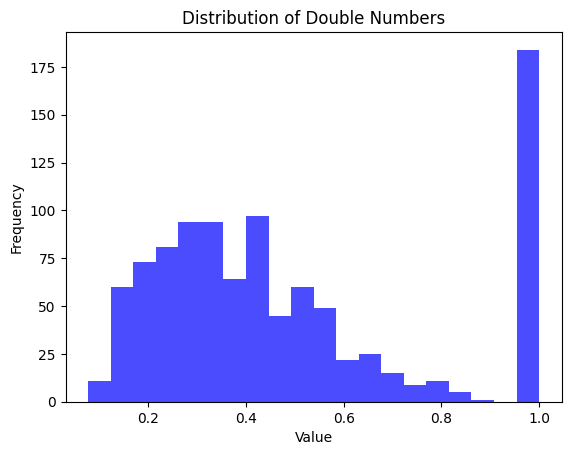

In [166]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(generated_scores, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
average_random_score, average_generated_score = get_average_score(x_train[2000:2100], y_train[2000:2100], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [164]:
generated_scores, average_random_score, average_generated_score = get_average_score(x_test[2000:3000], y_test[2000:3000], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

W0000 00:00:1717867182.235078     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Average score on shuffled data: 0.1437748238947166
Average score on generated data: 0.488652290575781


In [165]:
transformer.summary()

Model: "transformer_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_34         │ ?                      │     1,280,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_35         │ ?                      │     1,280,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_177         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_178         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_179         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_180         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_181         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_182         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_183         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_184         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_185         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_186         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_187         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_188         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_189         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_190         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_191         │ ?                      │       198,27

 Total params: 33,766,705 (128.81 MB)

 Trainable params: 11,255,568 (42.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,511,137 (85.87 MB)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(generated_scores, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
import numpy as np

# Assuming you have an array of double numbers
original_array = np.random.normal(loc=0, scale=1, size=10000)  # Example array

# Generate 5000 random indices within the range of the original array length
random_indices = np.random.choice(len(original_array), size=5000, replace=False)

# Get the elements at these random indices
random_elements = original_array[random_indices]

# Print the random indices and the corresponding elements
print("Random Indices:", random_indices)
print("Random Elements:", random_elements)


In [ ]:
def generate_prediction2(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0) 
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = generated_index
        generated_token = available_tokens[generated_index]
#         available_tokens.remove(generated_token)
        generated[count+1] = generated_token
    
    generated[sum(generated>0)] = 2
    return generated[:sum(generated>0)]
def get_average_score2(x, y, model):
    num_examples = len(x)
    rs = []
    gs = []
    for i in range(num_examples):
        shuffled = x[i][:sum(x[i]>0)]
        ordered = y[i][:sum(y[i]>0)]

        rs.append(score(ordered, shuffled))
        gs.append(score(ordered, generate_prediction2(x[i],model)))
        print(f'{i+1}.Random: {rs[-1]}')
        print(f'{i+1}.Generated: {gs[-1]}')

    return gs, sum(rs)/num_examples, sum(gs)/num_examples

In [ ]:
generated_scores, average_random_score, average_generated_score = get_average_score2(x_test[2000:3000], y_test[2000:3000], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')